# Случайные процессы. Прикладной поток.
## Практическое задание 5.
Правила:
∙ Выполненную работу нужно отправить на почту probability.diht@yandex.ru, ука- зав тему письма "[СП17] Фамилия Имя - Задание 5". Квадратные скобки обязатель- ны. Вместо Фамилия Имя нужно подставить свои фамилию и имя. <br>
∙ Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: 5.N.ipynb и 5.N.pdf, где N — ваш номер из таблицы с оценками. <br>
∙ Никакой код из данного задания при проверке запускаться не будет. <br>
Варианты:
0. http://ita.ee.lbl.gov/html/contrib/ClarkNet-HTTP.html <br>
1. http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html  <br>
2. http://ita.ee.lbl.gov/html/contrib/Calgary-HTTP.html <br>
3. http://ita.ee.lbl.gov/html/contrib/Sask-HTTP.html <br>
Нужно выбрать вариант 𝑁𝑚𝑜𝑑 4, где 𝑁 — ваш номер из таблицы с оценками. 


 ## Задание:
1. Загрузите в Питоне данные, соответствующие вашему варианту. Возможно, будет удобнее воспользоваться библиотекой pandas, в частности функцией read_csv. Некоторые записи в данных могут иметь неправильный формат, поэтому сначала файл с данными придется преобразовать. В процессе преобразовании можно проигнорировать не более 1% строк, в которых указана дата (если будете удалять, напечатайте долю удаленных строк). Строки, в которых дата не указана, нужно удалить. <br>
2. Переведите дату в timestamp-число с помощью библиотеки datetime. Например, дата 24/Oct/1994:13:41:41 преобразуется в число 782995301 с помощью кода
from datetime import datetime
datetime.strptime("24/Oct/1994:13:41:41", "%d/%b/%Y:%H:%M:%S").timestamp() Подробнее читайте в документациях к библиотекам datetime и time. <br>
3. Запросы, происходящие в некоторые моменты времени, образуют пуассоновский процесс, смысл которого — количество запросов, обработанных сервером к текущему моменту времени. Нарисуйте графики траектории этого пуассоновского процесса за все время и за первые сутки. Нарисуйте так же аналогичные графики составного пуассоновского процесса, взяв в качестве значений количество байт (bytes in the reply). При построении графиков используйте код с семинара.
1 <br>
4. Проверьте полученный пуассоновский процесс на однородность за все время, а так же за некоторые другие интервалы времени (месяц, неделя, сутки, час). Имеются ли интервалы, на которых процесс однороден? Чтобы проверить корректность работы реализованных критериев, можно проверить их на сгенерированных данных. Код для генерации можно взять с семинара. <br>
5. Постройте оценку функции интенсивности следующим образом. Разбейте весь временной интервал на небольшие равные по длине интервалы с достаточным количеством событий в каждом интервале (например, интерваля длинною в час). На каждом интервале оцените значение интенсивности процесса, считая его однородным на данном интервале. В какие моменты времени наблюдается наибольшая интенсивность? <br>
6. Для получения дополнительных баллов исследуйте, есть ли зависимость интенсивности от типа хоста (host); есть ли зависимость объема запроса в байтах от времени; какой пропускной способности должны быть серверы, чтобы обрабатывать все поступающие запросы.

In [592]:
import pandas as pd
from datetime import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline


In [593]:
import warnings
warnings.filterwarnings("ignore")

**1) Загружаем данные**

Сначала узнаем кол-во строк в нашей файле.

In [594]:
f1 = open('access_log_Jul95', mode='r', encoding='latin1')
count_lines1 = len(f1.readlines())
f2 = open('access_log_Aug95', mode='r', encoding='latin1')
count_lines2 = len(f2.readlines())

count_lines = count_lines1 + count_lines2

Выберем названия для столбцов DataFrame и создадим 2 DataFrame

In [595]:
names = ['host','blank1', 'blank2', 'timestamp', 'timezone', 'request', 'HTTP reply code', 'bytes in the reply']
frame1 = pd.read_csv('access_log_Jul95', encoding = 'latin1', sep=' ', names=names, error_bad_lines=False)
frame2 = pd.read_csv('access_log_Aug95', encoding = 'latin1', sep=' ', names=names, error_bad_lines=False)

Соединим получившееся в один DataFrame

In [596]:
frame = frame1.append(frame2)

Для удобства, удалим 2 столбца, соответствующие символам '-'

In [597]:
frame.drop('blank1', axis=1, inplace=True)
frame.drop('blank2', axis=1, inplace=True)

Также заметим, что в файле есть неправильные данные, а именно строки вида: <br>
frank.mtsu.edu - - [03/Jul/1995:02:41:15 -0400] "GET /images/" HTTP/1.0" 404 - <br>
В них есть три знака ", что приводит в неправильному распарсиванию. То есть в столбце 'HTTP reply code' будет некая строка, а не число  <br>
Уберем их:

In [598]:
reply_code = np.array(frame['HTTP reply code'])
indexes_to_delete = []
for i in range(len(frame)):
    try:
        temp = int(reply_code[i])
    except:
        indexes_to_delete.append(i)
        

In [599]:
frame.drop(frame.index[indexes_to_delete], inplace=True)

После этого также уберем строки, в которых в столбце 'bytes in the reply' стоит не число и не прочерк -.

In [600]:
bytes_reply = np.array(frame['bytes in the reply'])
indexes_to_delete = []
for i in range(len(frame)):
    try:
        if(bytes_reply[i] != '-'):
            temp = int(bytes_reply[i])
    except:
        indexes_to_delete.append(i)

In [601]:
frame.drop(frame.index[indexes_to_delete], inplace=True)

Найдем процент проигнорированных строк

In [602]:
print("Проигнорировали " +  str(100 - 100 * len(frame) / (count_lines)) + '% строк')

Проигнорировали 0.0018199608101809872% строк


Сильно меньше одного процента - хорошо.

Уберем строки, в которых не указана дата. <br>
Для этого сначала пустые значения заменим на новые значения (так как строки с NaN удалить не получилось), а затем удалим строки, у которых в timestamp стоит новое значение.

In [603]:
count_lines = len(frame)
frame.fillna('to remove', inplace=True)
frame = frame[frame.timestamp != 'to remove']

**2) Переводим дату**

Теперь переведем даты в timestamp-число <br>
Временная зона у всех строк одинакова и равна -0400, поэтому просто добавим ее к каждой дате

In [604]:
timestamps = np.array(frame.timestamp)
for i in range(len(timestamps)):
    timestamps[i] = datetime.strptime(timestamps[i][1:] + ' -0400', "%d/%b/%Y:%H:%M:%S %z").timestamp()

frame.timestamp = timestamps

**3) Рисуем графики**

In [552]:
jumps = np.array(frame.timestamp)

Построим график количества запросов от времени для первых 100 запросов

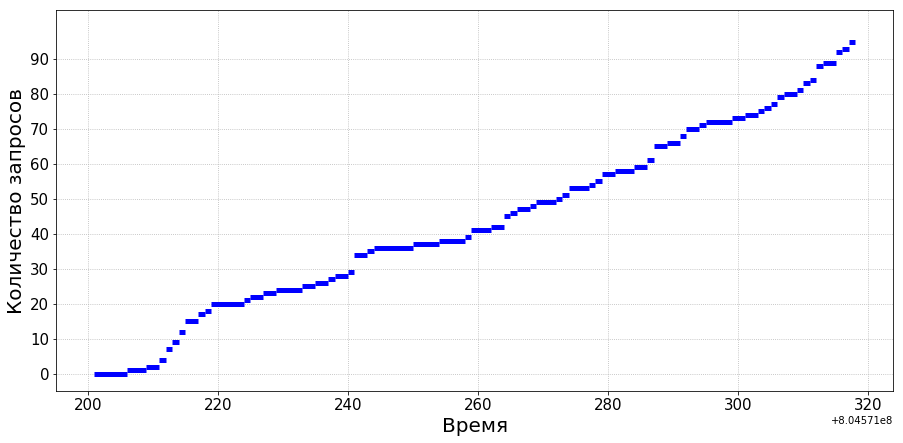

In [622]:
T = np.max(jumps[:100])
plt.figure(figsize=(15, 7))
for i in range(100):
    plt.hlines(i, jumps[i], min(jumps[i+1], T), lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(fontsize=15), plt.xlabel('Время', fontsize=20)
plt.yticks(range(0, 100, 10), fontsize=15), plt.ylabel('Количество запросов', fontsize=20)
plt.show()

Построим график для первых 1000 запросов

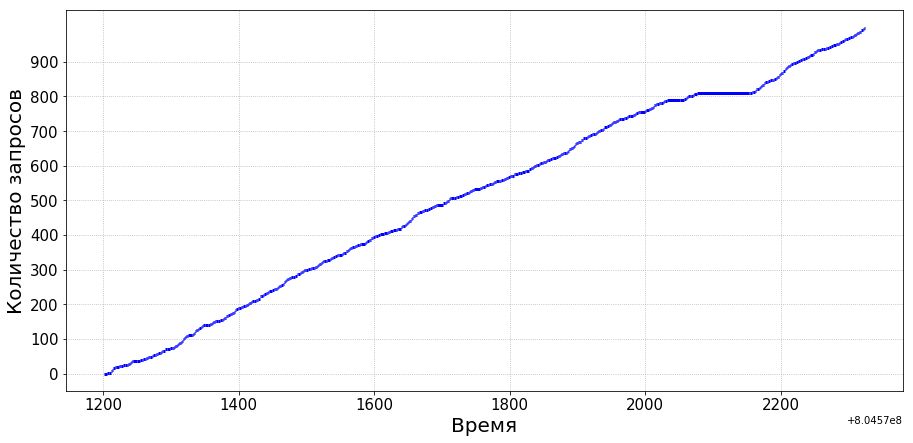

In [623]:
T = np.max(jumps[:1000])
plt.figure(figsize=(15, 7))
for i in range(1000):
    plt.hlines(i, jumps[i], min(jumps[i+1], T), lw=3, color='blue')
plt.grid(ls=':')
plt.xticks(fontsize=15), plt.xlabel('Время', fontsize=20)
plt.yticks(range(0, 1000, 100), fontsize=15), plt.ylabel('Количество запросов', fontsize=20)
plt.show()

Построим приближенный график для всего процесса.

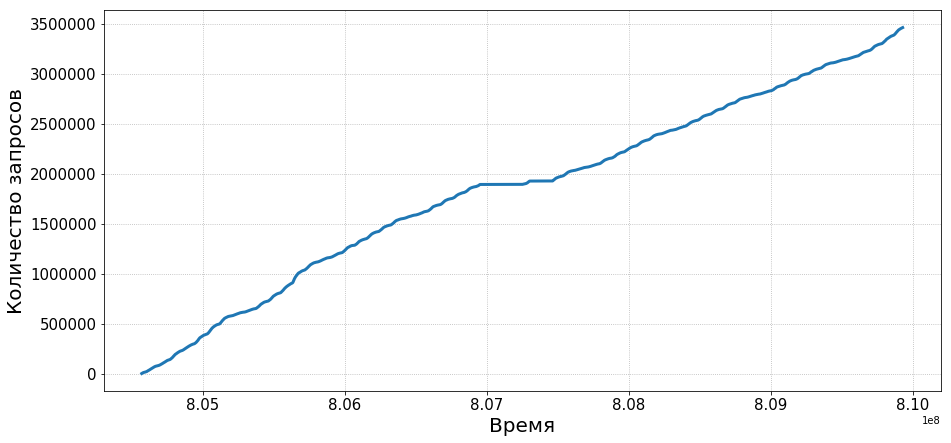

In [624]:
unique_jumps, counts = np.unique(jumps, return_counts=True)
numbers = counts.cumsum()
plt.figure(figsize=(15, 7))
plt.plot(unique_jumps, numbers, lw=3)
plt.xticks(fontsize=15), plt.xlabel('Время', fontsize=20)
plt.yticks(fontsize=15), plt.ylabel('Количество запросов', fontsize=20)
plt.grid(ls=':')
plt.show()

Создаем составной пуассоновский процесс. <br> <br>
В исхоных данных есть строки со значением '-' в графе bytes in the reply, у которых известно время запроса. Будем считать, что на такие запросы ответ составил 0 байт.

In [625]:
bytes_reply = np.array(frame['bytes in the reply'])
bytes_reply[bytes_reply == '-'] = '0'
bytes_reply = np.array(bytes_reply, dtype=int)
X = np.append(0, bytes_reply).cumsum()

Для первых 100 запросов

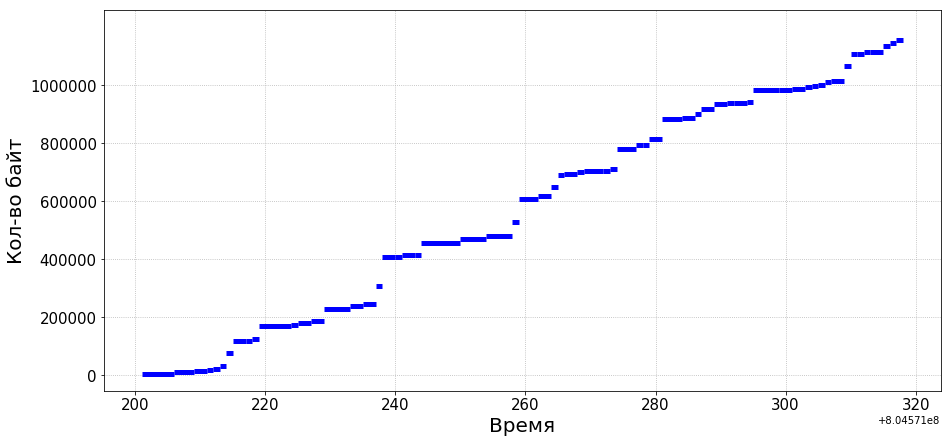

In [626]:
T = np.max(jumps[:100])
plt.figure(figsize=(15, 7))
for i in range(1, 100):
    plt.hlines(X[i], jumps[i-1] , jumps[i], lw=5, color='blue')
plt.hlines(int(X[100 - 1]), jumps[100 - 1], T, lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(fontsize=15), plt.xlabel('Время', fontsize=20)
plt.yticks(range(0, int(max(X[:100])), 200000), fontsize=15), plt.ylabel('Кол-во байт', fontsize=20)
plt.show()

Для первых 1000 запросов

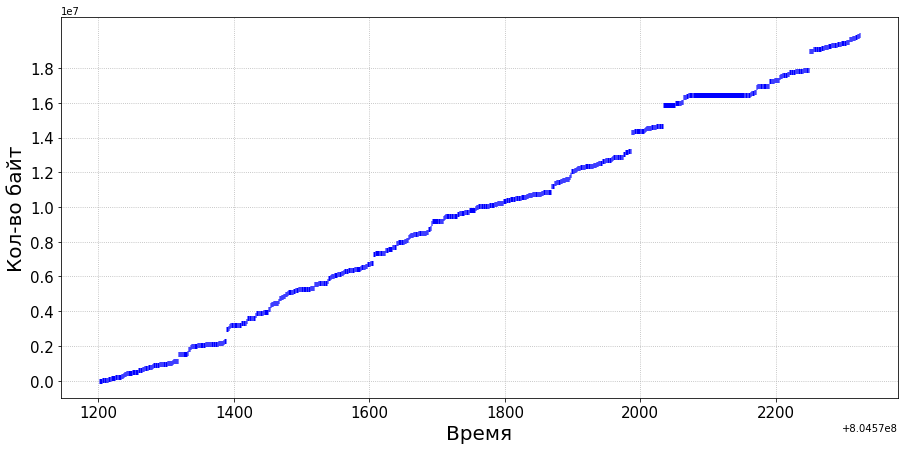

In [627]:
T = np.max(jumps[:1000])
plt.figure(figsize=(15, 7))
for i in range(1, 1000):
    plt.hlines(X[i], jumps[i-1], jumps[i], lw=5, color='blue')
plt.hlines(int(X[1000 - 1]), jumps[1000 - 1], T, lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(fontsize=15), plt.xlabel('Время', fontsize=20)
plt.yticks(range(0, int(max(X[:1000])), 2000000), fontsize=15), plt.ylabel('Кол-во байт', fontsize=20)
plt.show()

**4) Проверка на однородность** <br> <br>
Пусть $[\tau_1, \tau_2]$ - рассматриваемый интервал времени <br>
Разделим интервал $[\tau_1, \tau_2]$ на k равных частей. Будем использовать критерий хи-квадрат. <br> Ожидаемое число событий в каждом интервале - $\frac{n}{k}$, где $n$ - общее число событий.

In [560]:
#сделаем функцию,возвращающую массив кол-ва событий на интервалах разбиения
def array_chisquare(array, begin, T, k = 1000):
    '''
    begin - начало отсчета времени
    T - длина отрезка
    k - кол-во интервалов разбиения
    '''
    n_obs = []
    for i in range(1, k+1):
        temp = array[array >= begin + (i - 1)*T / k]
        n_obs.append(len(temp[temp <= begin + i*T / k]))
    return n_obs

Теперь проверяем на однородность: <br>
За всё время

In [561]:
k=1000

T = np.max(jumps) - np.min(jumps)
n = len(jumps)
n_exp = [n/k] * k
n_obs = array_chisquare(jumps, np.min(jumps), T)
print(sps.chisquare(n_obs, n_exp))

Power_divergenceResult(statistic=1597601.3529199348, pvalue=0.0)


За первый месяц

In [562]:
month = 30 * 24* 60*60
jumps_month = jumps[jumps <= jumps[0] + month]

n = len(jumps_month)
n_exp = [n/k] * k
n_obs = array_chisquare(jumps_month, np.min(jumps_month), month)
print(sps.chisquare(n_obs, n_exp))

Power_divergenceResult(statistic=885856.87205784488, pvalue=0.0)


За первую неделю

In [563]:
week = 7 * 24* 60 * 60
jumps_week = jumps[jumps <= jumps[0] + week]

n = len(jumps_week)
n_obs = array_chisquare(jumps_week, np.min(jumps_week), week)
print(sps.chisquare(n_obs, n_exp))

Power_divergenceResult(statistic=964664.70749116002, pvalue=0.0)


За день

In [564]:
day = 24* 60 * 60
jumps_day = jumps[jumps <= jumps[0] + day]

n = len(jumps_day)
n_exp = [n/k] * k
n_obs = array_chisquare(jumps_day, np.min(jumps_day), day)
print(sps.chisquare(n_obs, n_exp))

Power_divergenceResult(statistic=9946.4242447655088, pvalue=0.0)


За час

In [565]:
hour = 60* 60
jumps_hour = jumps[jumps <= jumps[0] + hour]

n = len(jumps_hour)
n_exp = [n/k] * k
n_obs = array_chisquare(jumps_hour, np.min(jumps_hour), hour)
print(sps.chisquare(n_obs, n_exp))

Power_divergenceResult(statistic=1637.3513589240683, pvalue=1.0169892527985686e-33)


Как видим, на часовом промежутке p-value перестал быть нулевым, но все же слишком маленький

Пол часа <br>
Для более точной картины будем рассматривать не первый час, а 100 произвольных часов

In [566]:
min_30 = 30* 60
results_min_30 = []
k = 1000
for i in range(100):
    index = random.randint(0, len(jumps) - 10000)
    temp = jumps[jumps <= jumps[index] + min_30]
    jumps_min_30  = temp[temp >= jumps[index]]

    n = len(jumps_min_30)
    n_exp = [n/k] * k
    n_obs = array_chisquare(jumps_min_30, np.min(jumps_min_30), min_30, k)
    results_min_30.append(sps.chisquare(n_obs, n_exp))

results_min_30 = np.array(results_min_30)
print('Минимальный p-value: ' +  str(np.min(results_min_30[:, 1])))
print('Максимальный p-value: ' + str(np.max(results_min_30[:, 1])))

Минимальный p-value: 3.67789454545e-282
Максимальный p-value: 2.7861776491e-12


Все равно мало

15 минут <br>
Также будем рассматривать 100 произвольных интервалов

In [569]:
min_15 = 15* 60
results_min_15 = []

k = 20
for i in range(100):
    index = random.randint(0, len(jumps) - 1000)
    temp = jumps[jumps <= jumps[index] + min_15]
    jumps_min_15  = temp[temp >= jumps[index]]
    
    n = len(jumps_min_15)
    n_exp = [n/k] * k
    n_obs = array_chisquare(jumps_min_15, np.min(jumps_min_15), min_15, k)
    results_min_15.append(sps.chisquare(n_obs, n_exp))


results_min_15 = np.array(results_min_15)
p_values = results_min_15[:, 1]
print('Минимальный p-value: ' +  str(np.min(p_values)))
print('Максимальный p-value: ' + str(np.max(p_values)))
print('Кол-во случаев, когда p-value получился > 0.05: ' + str(len(p_values[p_values > 0.05])))

Минимальный p-value: 8.96296972682e-116
Максимальный p-value: 0.213071092537
Кол-во случаев, когда p-value получился > 0.05: 1


Как видим на 15-ти минутном интервале процесс уже больше похож на однородный <br>
(На одином из 100 15-ти минутных промежутков на уровне 0.05 не отвергаем гипотезу об однородности процесса)

5 минут

In [575]:
min_5 = 5* 60
results_min_5 = []
k = 5

for i in range(100):
    index = random.randint(0, len(jumps) - 1000)
    temp = jumps[jumps <= jumps[index] + min_5]
    jumps_min_5  = temp[temp >= jumps[index]]
    
    n = len(jumps_min_5)
    n_exp = [n/k] * k
    n_obs = array_chisquare(jumps_min_5,np.min(jumps_min_5), min_5 , k)
    results_min_5.append(sps.chisquare(n_obs, n_exp))

results_min_5 = np.array(results_min_5)
p_values = results_min_5[:, 1]
print('Минимальный p-value: ' +  str(np.min(p_values)))
print('Максимальный p-value: ' + str(np.max(p_values)))
print('Кол-во случаев, когда p-value получился > 0.05: ' + str(len(p_values[p_values > 0.05])))

Минимальный p-value: 4.45119525909e-12
Максимальный p-value: 0.996328849123
Кол-во случаев, когда p-value получился > 0.05: 36


Здесь уже кол-во 5-ти минутных интервалов, на которых гипотеза об однородности не отвергается намного больше

1 минута

In [665]:
min_1 =  60
results_min_1 = []
k = 4

for i in range(100):
    index = random.randint(0, len(jumps) - 1000)
    temp = jumps[jumps <= jumps[index] + min_1]
    jumps_min_1  = temp[temp >= jumps[index]]
    
    n = len(jumps_min_1)
    n_exp = [n/k] * k
    n_obs = array_chisquare(jumps_min_1,np.min(jumps_min_1), min_1 , k)
    results_min_1.append(sps.chisquare(n_obs, n_exp))

results_min_1 = np.array(results_min_1)
p_values = results_min_1[:, 1]
print('Минимальный p-value: ' +  str(np.min(p_values)))
print('Максимальный p-value: ' + str(np.max(p_values)))
print('Кол-во случаев, когда p-value получился > 0.05: ' + str(len(p_values[p_values > 0.05])))

Минимальный p-value: 1.25027602747e-06
Максимальный p-value: 0.962692458511
Кол-во случаев, когда p-value получился > 0.05: 75


Таким образом, на большинстве 1-минутных интервалов процесс можно считать однородным.

Проверим на генерации простого однородного процесса

In [578]:
T = 20
l = 1
S = 0
xi = [0]
while S < T:
    xi.append(sps.expon(scale=1/l).rvs())
    S += xi[-1]
jumps_generation = np.cumsum(xi)

In [579]:
k = 10
n = len(jumps_generation)
n_exp = [n/k] * k
n_obs = array_chisquare(jumps_generation, 0,  T, k)
print(sps.chisquare(n_obs, n_exp))

Power_divergenceResult(statistic=13.444444444444446, pvalue=0.14350504606830258)


Таким образом, убедились, что p-value считается корректно. (так как сгенерированный процесс является однородным)

**5) Оценка функции интенсивности** <br> <br>
Для оценки интенсивности процесса  нужно вспомнить, что однородный пуассоновский процесс интенсивности $\lambda$ - это процесс восстановления, построенный по случайным величинам из экспоненциального распределения с параметром $\lambda$. В данном случае в качестве экспоненциально распределеннных величин выступают промежутки времени между запросами. Таким образом, в предположении, что промежутки времени между запросами распределены экспоненциально, нужно найти параметр распределения $\lambda$. Найдем его методом максимального правдоподобия: <br>
$f_{\lambda}(X_1, ..., X_n) = \lambda^n e^{-\lambda \sum_{i =1}^n X_i}$ <br>
$L_{\lambda}(X_1, ..., X_n) = nln(\lambda) -\lambda \sum_{i =1}^n X_i$ <br>
$L'_{\lambda}(X_1, ..., X_n) = \frac{n}{\lambda} - \sum_{i =1}^n X_i = 0$ <br>
$\Rightarrow \lambda^* = \frac{1}{\overline X}$ <br>
Будем рассматривать интервалы времени в 30 минут,так как в пределах такого интервала процесс более похож на однородный, чем в пределах часа, а в 15-ти минутном интервале уже слишком мало запросов.

In [654]:
lambdas = []
time = 30*60
i = 0

#времена начал интервалов
sequence_time = []

#разница по времени между скачками
xi = (jumps - np.append(0, jumps[:-1]))[1:]

while(i < len(jumps)):
    sequence_time.append(jumps[i])
    
    temp = jumps[jumps <= jumps[i] + time]
    jumps_min_30  = temp[temp >= jumps[i]]

    lambdas.append(1 / np.mean(xi[i:i + len(jumps_min_30)]))
    i = i + len(jumps_min_30)


lambdas = np.array(lambdas)
print('Максимальная интенсивность: ' + str(np.max(lambdas)))
print('Время максимальной интенсивности: ' + str(datetime.fromtimestamp(time * np.argmax(lambdas) + jumps[0])))
print('Время максимальной интенсивности(в секундах): ' + str(time * np.argmax(lambdas) + jumps[0]))
print('Минимальная интенсивность: ' + str(np.min(lambdas)))
print('Время минимальной интенсивности: ' + str(datetime.fromtimestamp(time * np.argmin(lambdas) + jumps[0])))
print('Время минимальной интенсивности(в секундах): ' + str(time * np.argmin(lambdas) + jumps[0]))
print('Средняя интенсивность: ' + str(np.mean(lambdas)))

Максимальная интенсивность: 4.16823986674
Время максимальной интенсивности: 1995-07-13 17:00:01
Время максимальной интенсивности(в секундах): 805640401.0
Минимальная интенсивность: 0.00153084741657
Время минимальной интенсивности: 1995-07-28 20:00:01
Время минимальной интенсивности(в секундах): 806947201.0
Средняя интенсивность: 0.703606826658


Видим, что максимальная эффективность пришлась на дату 1995-07-13 17:00:01. <br>
В эту день произошла миссия TDRS-G по запуску Space Shuttle 'Discovery'.

Построим графики зависимости интенсивности от времени

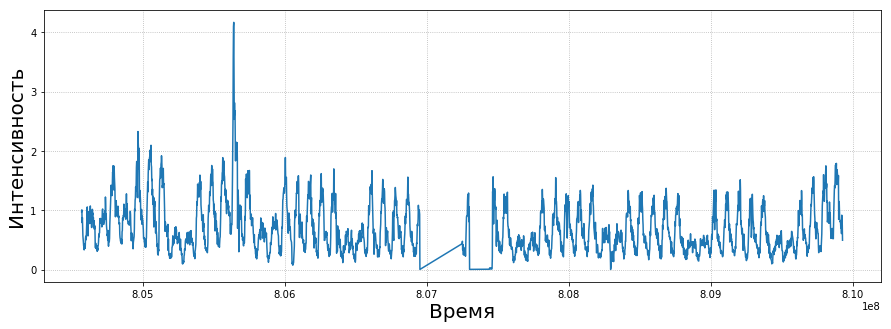

In [655]:
plt.figure(figsize=(15, 5))
plt.plot(sequence_time, lambdas)
plt.grid(ls=':')
plt.xlabel('Время', fontsize=20)
plt.ylabel('Интенсивность', fontsize=20)
plt.legend()
plt.show()

Странный вид графика посередине связан с тем, что в это время сервер не работал. <br>
(Промежуток между делениями соответствует примерно 11.5 дням) <br>
Из графика также можно повторно сделать вывод, что в интервалах >= час процесс совсем не похож на однородный.

Посмотрим теперь в какое время дня активность больше.

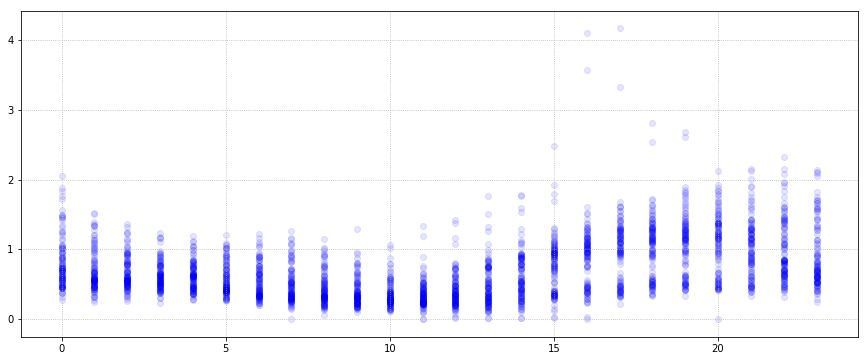

In [641]:
plt.figure(figsize=(15, 6))
for i in range(len(lambdas)):
    data = datetime.fromtimestamp(time * i + jumps[0]).hour
    plt.scatter(data, lambdas[i], color='blue', alpha=0.1)
plt.grid(ls=':')
plt.show()

Из графика видно, что в среднем часы максимальной интенсивности : 20-23 часа

Таким образом, на построенных графиках убеждаемся, что запросы на сервер похожи на пуассоновский процесс. <br>
Этот процесс не является однородным, однородным его можно считать на итервалах <= 1 минуты (так как на интервалах <= 1 минут гипотеза об однородности в большинстве случаев не отвергается). <br>
Также исследовали интенсивность процесса в разные промежутки времени и определили даты и часы максимальной интенсивности.